# Paramaterial Usage Example

Importing the paramaterial module

In [1]:
import pandas as pd
# import paramaterial as a module
import paramaterial as pam

# check the version of paramaterial
print('paramaterial', pam.__version__)

paramaterial 0.1.0


Load the raw data and metadata into a DataSet object

In [2]:
# load the metadata spreadsheet and data files into a DataSet object
prepared_ds = pam.DataSet('info/01 prepared info.xlsx', 'data/01 prepared data')

# check the formatting of the loaded data and metadata
pam.check_formatting(prepared_ds)

Checking column headers...
First file headers:
	['Strain', 'Stress_MPa']
Headers in all files are the same as in the first file, except for None.
Checking for duplicate files...
No duplicate files found in "data/01 prepared data".


Sort and Get the metadata as a pandas DataFrame

In [3]:
# sort the dataitems in the dataset
prepared_ds = prepared_ds.sort_by(['temperature', 'lot'])

# get the metadata as a table
# prepared_ds.info_table

Use the subset method to get a subset of the data

In [4]:
# get a subset of only the tensile tests
prepared_ds = prepared_ds.subset({'test_type': ['T']})

Make an experimental matrix showing the distribution of the data

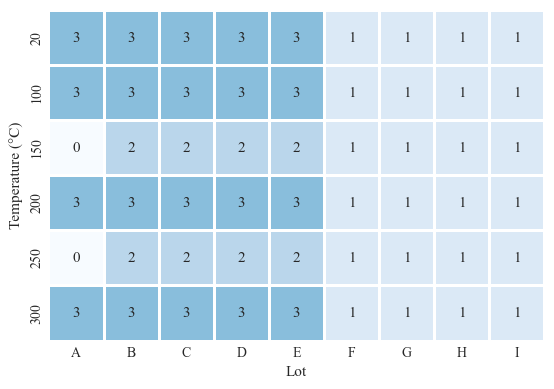

In [5]:
# make a heatmap showing the distribution across lot and temperature
pam.experimental_matrix(info_table=prepared_ds.info_table, xlabel='Lot', ylabel='Temperature (°C)',
                        index='temperature', vmax=7, columns='lot', as_heatmap=True);

Use a Styler object to format the plotting to the entire dataset

In [6]:
# instantiate a Styler object and format to match the prepared data
styler = pam.Styler(color_by='temperature', color_by_label='(°C)', cmap='plasma')
styler.style_to(prepared_ds)

# keys labels for stress-strain data plotting
labels_dict = dict(x='Strain', y='Stress_MPa', xlabel='Strain (mm/mm)', ylabel='Stress (MPa)')

Setup the dataset plot for a single plot of all the data

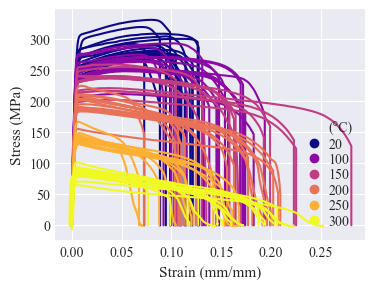

In [7]:
# define a function to plot the dataset
def ds_plot(ds, **kwargs):
    """Takes in a DataSet and extra plotting kwargs, returns a matplotlib Axes object."""
    return pam.dataset_plot(ds=ds, styler=styler, **labels_dict, **kwargs)

# plot the dataset
ds_plot(prepared_ds);

Setup the dataset plot for a grid of plots of the data.

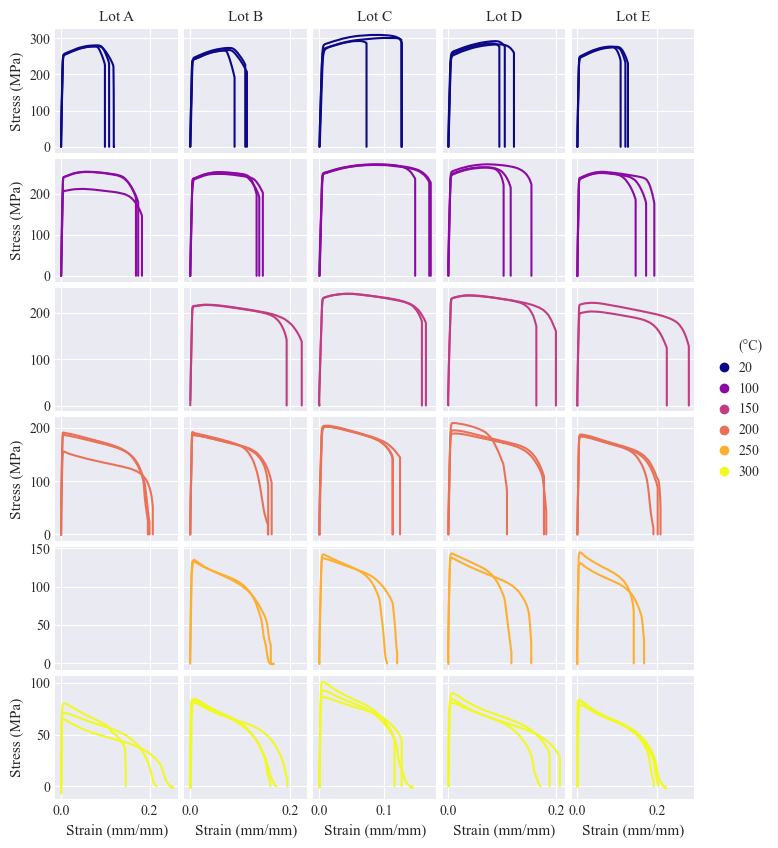

In [8]:
# define a function to plot the dataset as a grid of plots
def ds_subplots(ds, **kwargs):
    """Takes in a DataSet and extra plotting kwargs, returns an array of matplotlib Axes objects."""
    return pam.dataset_subplots(
        ds=ds, shape=(6, 5), styler=styler, figsize=(9., 10.),
        rows_by='temperature', row_vals=[[20], [100], [150], [200], [250], [300]],
        cols_by='lot', col_vals=[['A'], ['B'], ['C'], ['D'], ['E']],
        col_titles=[f'Lot {lot}' for lot in 'ABCDE'], **labels_dict, **kwargs)

# plot the dataset as a grid of plots
ds_subplots(prepared_ds);

## Processing
Find UTS and fracture point.

In [9]:
# determine the ultimate tensile strength for each test
prepared_ds = pam.find_UTS(ds=prepared_ds, strain_key='Strain',
                           stress_key='Stress_MPa')

# determine the fracture point for each test
prepared_ds = pam.find_fracture_point(ds=prepared_ds, strain_key='Strain',
                                      stress_key='Stress_MPa')

Trimming.

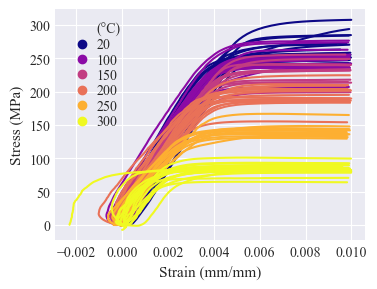

In [10]:
# define a function to trim the data to a small strain range
def trim_to_small_strain(di):
    """Takes in a DataItem and returns a trimmed DataItem."""
    di.data = di.data[di.data['Strain'] < 0.01]
    return di


# apply the function to the dataset
trimmed_ds = prepared_ds.apply(trim_to_small_strain)

# plot the trimmed dataset
ds_plot(trimmed_ds);

Apply foot correction.

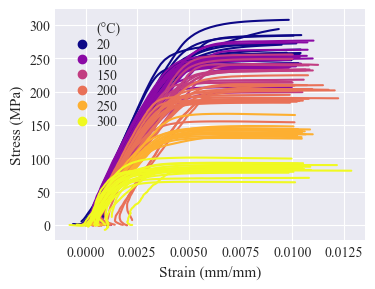

In [11]:
# determine the upper and lower proportional limits for each test
trimmed_ds = pam.find_upl_and_lpl(ds=trimmed_ds, preload=36,
                                  preload_key='Stress_MPa')

# apply the foot correction to the dataset
corrected_ds = pam.correct_foot(ds=trimmed_ds, LPL_key='LPL', UPL_key='UPL')

# plot the corrected dataset
ds_plot(corrected_ds);

Make screening pdf for foot correction screening.

In [12]:
# define a function to plot a single test for foot correction screening
def foot_correction_screening_plot(di):
    """Takes in a DataItem and returns a matplotlib Axes object."""
    color = styler.color_dict[di.info['temperature']]
    LPL = (di.info['UPL_0'], di.info['UPL_1'])
    UPL = (di.info['LPL_0'], di.info['LPL_1'])
    ax = ds_plot(corrected_ds.subset({'test_id': di.test_id}))
    ax = ds_plot(trimmed_ds.subset({'test_id': di.test_id}), alpha=0.5, ax=ax)
    ax.axline(UPL, slope=di.info['E'], c=color, ls='--', alpha=0.5)
    ax.plot(*UPL, c=color, marker=4)
    ax.plot(*LPL, c=color, marker=5)
    return ax


# make the screening pdf
pam.make_screening_pdf(corrected_ds, plot_func=foot_correction_screening_plot,
                       pdf_path='info/foot-correction screening.pdf')

  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
100%|██████████| 1/1 [00:00<00:00,  7.94DataItems/s]
                                                    
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                            
  0%|          | 0/1 [00:00<?, ?DataItems/s]
                                       

Screening pdf saved to info/foot-correction screening.pdf.


Read screening pdf.

In [13]:
# read the annotated screening pdf fields to the dataset
corrected_ds = pam.read_screening_pdf(ds=corrected_ds,
                                      pdf_path='info/screening-marked.pdf')

# get the metadata table of the rejected items
corrected_ds.info_table[corrected_ds.info_table['reject'] == 'True']

,test_id,test_type,temperature,lot,number,rate,UTS_1,UTS_0,FP_0,FP_1,UPL_0,UPL_1,LPL_0,LPL_1,E,foot correction,reject,comment
52,test_ID_107,T,200,A,3,0.000866,191.370192,0.004679,0.195903,0.0,0.004655,162.188066,0.004477,155.988581,34841.418024,0.002293,True,Foot correction failed
57,test_ID_112,T,200,C,2,0.000866,202.162945,0.010931,0.112664,0.0,0.004615,159.315233,0.004503,155.435889,34520.870582,0.002079,True,Foot correction failed
60,test_ID_115,T,200,D,2,0.000866,189.531829,0.011615,0.181135,0.0,0.003882,157.454776,0.002624,106.442939,40562.804428,0.000913,True,Foot correction failed
66,test_ID_121,T,200,G,1,0.000866,204.657485,0.006201,0.103264,0.0,0.004985,165.156659,0.004870,161.336232,33129.036280,0.001829,True,Foot correction failed
82,test_ID_137,T,300,A,2,0.000866,70.754951,0.009688,0.215794,0.0,0.001735,56.773297,0.001303,42.631026,32718.700454,0.000935,True,Foot correction failed
91,test_ID_146,T,300,D,2,0.000866,84.225216,0.005785,0.206185,0.0,0.002307,66.955333,0.001652,47.934743,29016.845086,0.001262,True,Foot correction failed
97,test_ID_152,T,300,G,1,0.000866,87.721225,0.006013,0.118070,0.0,0.002953,71.698287,0.001928,46.815961,24281.088137,0.001265,True,Foot correction failed
98,test_ID_153,T,300,H,1,0.000866,89.998001,0.008500,0.076344,0.0,0.004018,77.331334,0.003916,75.352152,19243.887551,0.002299,True,Foot correction failed


Remove the rejected items

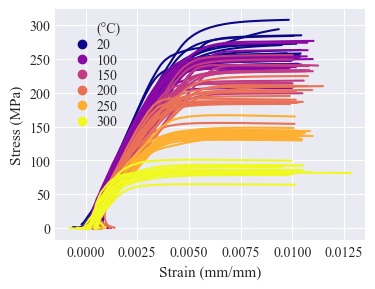

In [14]:
# remove the rejected tests from the dataset
screened_ds = pam.remove_rejected_items(ds=corrected_ds, reject_key='reject')

# plot the screened dataset
ds_plot(screened_ds);

Algorithmically find the proof stresses.

In [15]:
# find the 0.2% proof stress for each test
screened_ds = pam.find_proof_stress(ds=screened_ds, proof_strain=0.002, E_key='E',
                                    strain_key='Strain', stress_key='Stress_MPa')

Write processed data.

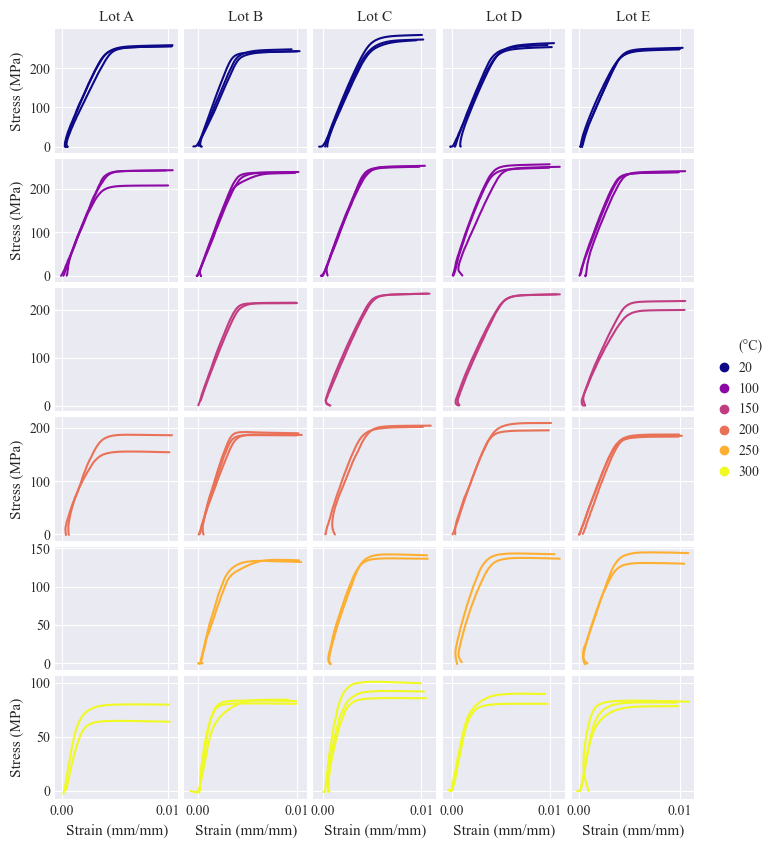

In [16]:
# write the metadata table data files to the specified paths
screened_ds.write_output('info/02 processed info.xlsx',
                         'data/02 processed data')

# load the processed dataset
processed_ds = pam.DataSet('info/02 processed info.xlsx',
                           'data/02 processed data')

# plot the processed dataset as a grid of plots
ds_subplots(processed_ds);

## Data Aggregation

Generate representative curves.

,repres_id,temperature,test_type,nr averaged,UTS_0,std_UTS_0,upstd_UTS_0,downstd_UTS_0,max_UTS_0,min_UTS_0,...,upstd_PS_0.002_1,downstd_PS_0.002_1,max_PS_0.002_1,min_PS_0.002_1,UPL_1,std_UPL_1,upstd_UPL_1,downstd_UPL_1,max_UPL_1,min_UPL_1
0,repres_id_0001,20,T,19,0.079107,0.021834,0.100941,0.057273,0.112621,-0.000003,...,275.880567,241.856732,303.288813,239.793067,163.246165,44.908715,208.154879,118.337450,227.601529,56.376929
1,repres_id_0002,100,T,19,0.068825,0.014578,0.083403,0.054247,0.102815,0.046793,...,259.930699,228.991904,274.251364,205.940530,145.231324,53.801048,199.032372,91.430277,218.947674,44.360834
2,repres_id_0003,150,T,12,0.034143,0.014221,0.048364,0.019923,0.051213,0.005640,...,245.143861,212.469294,254.641156,197.475471,130.886697,47.852359,178.739056,83.034339,214.622690,43.690351
3,repres_id_0004,200,T,15,0.008906,0.003166,0.012071,0.005740,0.014645,0.004576,...,209.101928,177.430107,222.924746,154.137294,127.849641,36.140337,163.989978,91.709305,188.358408,51.966869
4,repres_id_0005,250,T,12,0.006281,0.000644,0.006924,0.005637,0.007698,0.005563,...,150.500565,130.827037,166.618852,129.812602,86.387217,27.020760,113.407976,59.366457,119.090300,43.099975
5,repres_id_0006,300,T,15,0.006618,0.001686,0.008304,0.004933,0.009552,0.004365,...,91.081907,74.736629,100.316796,64.700178,53.174074,8.132525,61.306599,45.041549,69.881043,40.970355


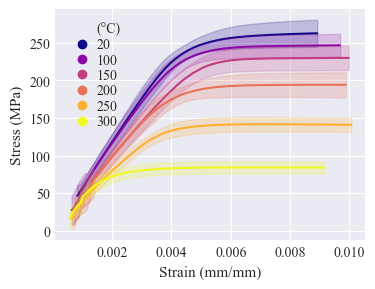

In [17]:
# make representative curves for each temperature and test type
pam.make_representative_data(
    ds=processed_ds, info_path='info/03 repres info.xlsx',
    data_dir='data/03 repres data', repres_col='Stress_MPa',
    interp_by='Strain', interp_range='inner',
    group_by_keys=['temperature', 'test_type'],
    group_info_cols=['UTS_0', 'UTS_1', 'FP_0', 'E',
                     'PS_0.002_0', 'PS_0.002_1', 'UPL_1'])

# load the representative dataset
repres_ds = pam.DataSet('info/03 repres info.xlsx',
                        'data/03 repres data',
                        test_id_key='repres_id')

# plot representative curves with standard deviation bands
ds_plot(repres_ds,
        fill_between=('down_std_Stress_MPa', 'up_std_Stress_MPa'));

# get the metadata table of the representative dataset
repres_ds.info_table

Fit models.

In [18]:
# get the Ramberg-Osgood model function
ramberg_func = pam.models.ramberg

# set up the modelset, variables are known, params are unknown
ramberg_ms = pam.ModelSet(
    model_func=pam.models.ramberg,
    var_names=['E', 'UPL_1'],
    param_names=['H', 'n'],
    bounds=[(0., 1000.), (0.01, 0.8)]
)

# fit the modelset to the representative dataset
ramberg_ms.fit_to(repres_ds, x_key='Strain', y_key='Stress_MPa')

# get a table of the fitted parameters
ramberg_ms.fitting_table  # paramaterial version 0.1.0
# ramberg_ms.fitting_results  # paramaterial version 0.1.3 and later

,model_id,var_E,var_UPL_1,H,n,error,repres_id,temperature,test_type,nr averaged,...,upstd_PS_0.002_1,downstd_PS_0.002_1,max_PS_0.002_1,min_PS_0.002_1,UPL_1,std_UPL_1,upstd_UPL_1,downstd_UPL_1,max_UPL_1,min_UPL_1
0,model_id_1,59628.248707,163.246165,216.887867,0.137071,6.150327,repres_id_0001,20,T,19,...,275.8805673494131,241.8567319175537,303.2888133397275,239.793067159071,163.2461647478644,44.90871461163925,208.1548793595036,118.3374501362251,227.601528876447,56.3769290357358
0,model_id_2,59197.69737,145.231324,195.87371,0.117204,19.360851,repres_id_0002,100,T,19,...,259.930698807364,228.9919041778251,274.2513636288905,205.9405298924262,145.2313242222233,53.80104767563203,199.0323718978553,91.43027654659123,218.94767432926,44.360833762824
0,model_id_3,49614.440999,130.886697,176.805596,0.10164,16.498866,repres_id_0003,150,T,12,...,245.1438609366658,212.4692943734326,254.6411560921753,197.4754711747367,130.8866971883324,47.85235864013476,178.7390558284671,83.03433854819761,214.622689722153,43.69035133474
0,model_id_4,49614.170264,127.849641,137.248235,0.130328,10.599846,repres_id_0004,200,T,15,...,209.1019282344099,177.4301065734037,222.924745775949,154.137293906848,127.8496412223169,36.14033655478509,163.989977777102,91.70930466753185,188.358407583882,51.966869050494
0,model_id_5,40589.92833,86.387217,96.708927,0.101779,9.791563,repres_id_0005,250,T,12,...,150.5005651435365,130.8270373742148,166.6188518421218,129.8126019450262,86.38721691376325,27.02075956197885,113.4079764757421,59.3664573517844,119.090300315133,43.099975477242
0,model_id_6,45465.780374,53.174074,67.156683,0.143618,5.838482,repres_id_0006,300,T,15,...,91.08190681069263,74.73662918463475,100.3167964300162,64.70017770092298,53.17407384837998,8.132524808343796,61.30659865672378,45.04154904003619,69.8810427182453,40.9703547439299


Predict data from fitted models.

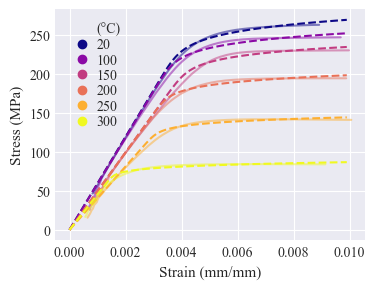

In [19]:
# Predict a dataset from the modelset
ramberg_ds = ramberg_ms.predict()

# Plot the fitted curves above the representative curves
ax = ds_plot(repres_ds, alpha=0.5)
ds_plot(ramberg_ds, ls='--', ax=ax);

## Quality Control


Check for outliers.

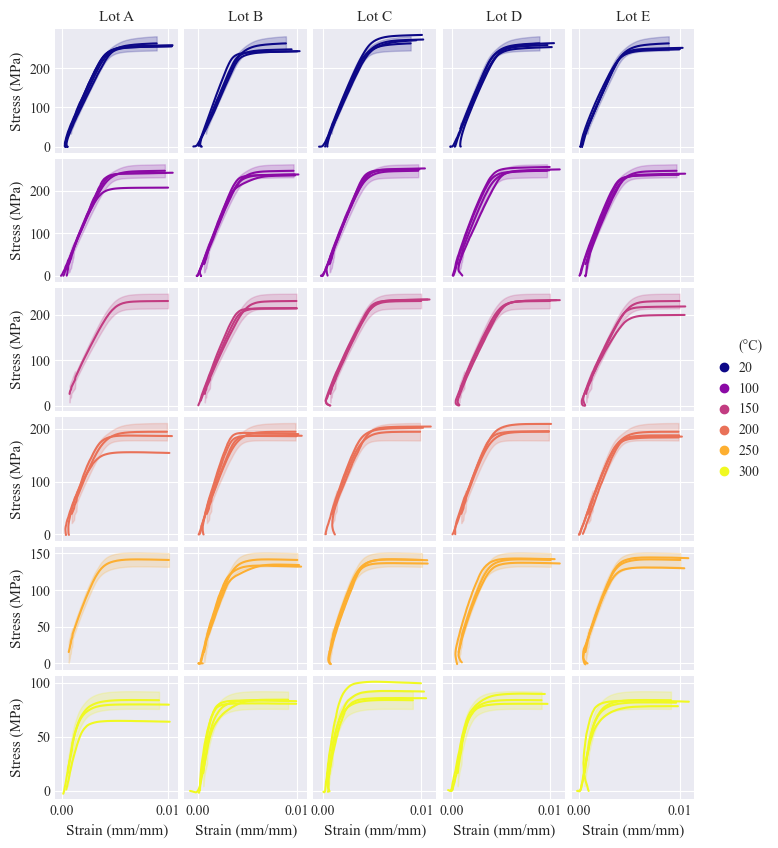

In [20]:
# Plot the processed curves on a grid of subplots
axs = ds_subplots(processed_ds)

# Plot the representative curve for a row on all the plots in that row
for i, temp in enumerate(processed_ds.info_table['temperature'].unique()):
    for j in range(axs.shape[1]):
        ax = axs[i, j]
        ds_plot(ds=repres_ds.subset({'temperature': temp}),
                ax=axs[i, j], plot_legend=False,
                fill_between=('up_std_Stress_MPa', 'down_std_Stress_MPa'))

Read placeholders from the test report template.

In [21]:
receipts = pam.TestReceipts(template_path=r'info/receipts_template.tex')
receipts.parse_placeholders(as_dict=True)

{'test_id': None, 'plot_raw': None, 'plot_processed': None, 'table_info': None}

Setup functions for the test reports.

In [22]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt


def receipts_raw_plot(di):
    test_id = di.test_id
    color = styler.color_dict[di.info['temperature']]
    UTS = (di.info['UTS_0'], di.info['UTS_1'])
    ax = ds_plot(prepared_ds.subset({'test_id': test_id}), title=f'Raw Data')
    ax.plot(*UTS, color=color, marker='s', label='UTS')
    plot_name = f'{test_id} raw.pdf'
    handles = [mlines.Line2D([], [], color=color, marker='s', ls='None', label='UTS')]
    ax.legend(handles=handles, loc='best')
    plt.savefig(plot_name, bbox_inches='tight', dpi=150)
    return plot_name


def receipts_processed_plot(di):
    test_id = di.test_id
    color = styler.color_dict[di.info['temperature']]
    UPL = (di.info['UPL_0'], di.info['UPL_1'])
    LPL = (di.info['LPL_0'], di.info['LPL_1'])
    PS_0_002 = (di.info['PS_0.002_0'], di.info['PS_0.002_1'])
    ax = ds_plot(trimmed_ds.subset({'test_id': di.test_id}), alpha=0.5)
    ds_plot(corrected_ds.subset({'test_id': di.test_id}), ax=ax, title='Processed Data')
    ax.axline(UPL, slope=di.info['E'], c=color, ls='--', alpha=0.5)
    ax.axline(PS_0_002, slope=di.info['E'], c=color, ls='--', alpha=0.5)
    ax.plot(*UPL, c=color, marker=4)
    ax.plot(*LPL, c=color, marker=5)
    ax.plot(*PS_0_002, c=color, marker='*')
    handles = [mlines.Line2D([], [], color=color, marker=4, ls='None', label='UPL'),
               mlines.Line2D([], [], color=color, marker=5, ls='None', label='LPL'),
               mlines.Line2D([], [], color=color, marker='*', ls='None', label='PS_0.002')]
    plot_name = f'{test_id} processed.pdf'
    ax.legend(handles=handles, loc='best')
    plt.savefig(plot_name, bbox_inches='tight', dpi=150)
    return plot_name


def receipts_table(di):
    series = di.info
    for key in ['UTS_1', 'UPL_1', 'LPL_1', 'PS_0.002_1', 'E']:
        series[key] = round(series[key], 2)
    for key in ['UTS_0', 'UPL_0', 'LPL_0', 'PS_0.002_0', 'FP_0']:
        series[key] = round(series[key], 4)
    table_string = series.to_frame().style.to_latex()
    return table_string

Generate the test reports.

In [23]:
# Define a dictionary of functions for replacing the placeholders
replace_dict = {'test_id': lambda di: di.test_id,
                'plot_raw': receipts_raw_plot,
                'plot_processed': receipts_processed_plot,
                'table_info': receipts_table}

# Generate the combined test receipts PDF
receipts.generate_receipts(ds=processed_ds,
                           receipts_path='info/test_receipts.pdf',
                           replace_dict=replace_dict);

## Analysis and Comparison

### Reference results

In [24]:
reference_table = pd.read_excel('info/aakash results.xlsx')
old_columns = ['Temperature', 'Elastic Modulus (GPa)', 'std_Elastic Modulus (GPa)', 'Tensile Yield Stress (MPa)', 'std_Tensile Yield Stress (MPa)', 'Tensile Ultimate Stress (MPa)', 'Tensile Ultimate Stress Std Dev (MPa)', 'Strain at Yield Stress (%)', 'Strain at Yield Stress Std Dev (%)', 'Strain at Ultimate Stress (%)', 'Strain at Ultimate Stress Std Dev (%)', 'Strain at Failure (%)', 'Strain at Failure Std Dev (%)']
new_columns = ['temperature', 'E', 'std_E', 'PS_0.002_1', 'std_PS_0.002_1', 'UTS_1', 'std_UTS_1', 'PS_0.002_0', 'std_PS_0.002_0', 'UTS_0', 'std_UTS_0',  'FP_0', 'std_FP_0']
reference_table = reference_table.rename(columns=dict(zip(old_columns, new_columns)))
reference_table

,temperature,E,std_E,PS_0.002_1,std_PS_0.002_1,UTS_1,std_UTS_1,PS_0.002_0,std_PS_0.002_0,UTS_0,std_UTS_0,FP_0,std_FP_0
0,20,60.5,5.40,259.0,16.90,288.0,17.80,0.632,0.0517,8.230,1.00,10.8,2
1,100,59.1,5.48,245.0,15.50,261.0,17.50,0.618,0.0594,6.910,1.00,14.7,3
2,150,51.0,4.47,229.0,16.50,234.0,16.70,0.647,0.0572,3.470,1.00,17.9,5
3,200,5.2,5.86,194.0,14.40,195.0,14.80,0.589,0.0729,0.924,0.30,15.0,4
4,250,40.3,3.79,141.0,9.89,142.0,9.54,0.551,0.0355,0.686,0.05,11.7,3
5,300,39.7,9.06,82.9,7.96,84.1,8.02,0.418,0.0476,0.724,0.20,15.2,4


### Analysis results

In [25]:
# make a table of the mechanical properties, E, FP_0, UTS_0, UTS_1, PS_0.002_0, PS_0.002_1
analysis_table = repres_ds.info_table[['temperature', 'E', 'FP_0', 'UTS_0', 'std_UTS_0', 'UTS_1', 'std_UTS_1', 'PS_0.002_0', 'std_PS_0.002_0', 'PS_0.002_1',  'std_PS_0.002_1','std_E', 'std_FP_0']].copy()

In [26]:
analysis_table

,temperature,E,FP_0,UTS_0,std_UTS_0,UTS_1,std_UTS_1,PS_0.002_0,std_PS_0.002_0,PS_0.002_1,std_PS_0.002_1,std_E,std_FP_0
0,20,59628.248707,0.107868,0.079107,0.021834,288.019326,18.287659,0.006393,0.000582,258.868650,17.011918,6375.922937,0.014909
1,100,59197.697370,0.147072,0.068825,0.014578,261.110786,17.526771,0.006206,0.000693,244.461301,15.469397,7688.573168,0.029273
2,150,49614.440999,0.178724,0.034143,0.014221,234.210400,16.665469,0.006665,0.000653,228.806578,16.337283,5108.847997,0.048437
3,200,49614.170264,0.153022,0.008906,0.003166,194.829980,16.419596,0.005965,0.000711,193.266017,15.835911,5647.964284,0.044474
4,250,40589.928330,0.123288,0.006281,0.000644,141.861776,9.543858,0.005508,0.000411,140.663801,9.836764,5461.025932,0.035832
5,300,45465.780374,0.169102,0.006618,0.001686,84.308414,8.159321,0.003900,0.000400,82.909268,8.172639,10693.642010,0.041004


### Comparison plots

In [27]:
import matplotlib as mpl
figsize=(3.6,2.8)
mpl.rcParams['text.usetex'] = True  

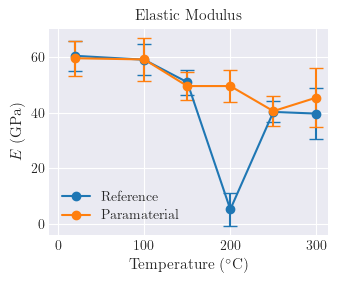

In [28]:
# divide E by 1000 to get GPa
analysis_table['E'] = analysis_table['E'] / 1000
analysis_table['std_E'] = analysis_table['std_E'] / 1000
# make a plot comparing E, include error bars for std deviations
ax=reference_table.plot(x='temperature', y='E', yerr='std_E', label='Reference', marker='o',  capsize=5, figsize=(3.6,2.68))
analysis_table.plot(x='temperature', y='E', yerr='std_E', label='Paramaterial', marker='o', capsize=5, ax=ax)
ax.set(xlabel='Temperature ($^{\circ}$C)', ylabel='$E$ (GPa)', title='Elastic Modulus', xlim=(-10, None));

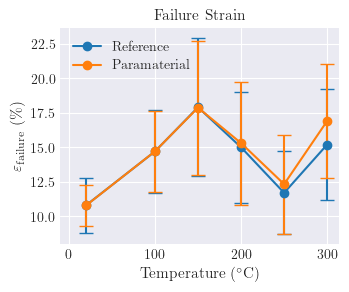

In [29]:
# convert paramaterial FP_0 to percent
analysis_table['FP_0'] = analysis_table['FP_0'] * 100
analysis_table['std_FP_0'] = analysis_table['std_FP_0'] * 100
# make a plot comparing FP_0, include error bars for std deviations
ax=reference_table.plot(x='temperature', y='FP_0', yerr='std_FP_0', label='Reference', marker='o',  capsize=5, figsize=figsize)
analysis_table.plot(x='temperature', y='FP_0', yerr='std_FP_0', label='Paramaterial', marker='o', capsize=5, ax=ax)
ax.set(xlabel='Temperature ($^{\circ}$C)', ylabel='$\\varepsilon_{\\text{failure}}$ (\%)', title='Failure Strain',xlim=(-10, None));

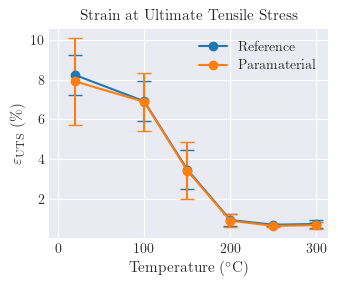

In [30]:
# convert analysis UTS_0 to percent
analysis_table['UTS_0'] = analysis_table['UTS_0'] *100
analysis_table['std_UTS_0'] = analysis_table['std_UTS_0'] *100
# make a plot comparing UTS_0, include error bars for std deviations
ax=reference_table.plot(x='temperature', y='UTS_0', yerr='std_UTS_0', label='Reference', marker='o',  capsize=5, figsize=(3.6,2.72))
analysis_table.plot(x='temperature', y='UTS_0', yerr='std_UTS_0', label='Paramaterial', marker='o', capsize=5, ax=ax)
ax.set(xlabel='Temperature ($^{\circ}$C)', ylabel='$\\varepsilon_{\\text{UTS}}$ (\%)', title='Strain at Ultimate Tensile Stress',xlim=(-10, None));

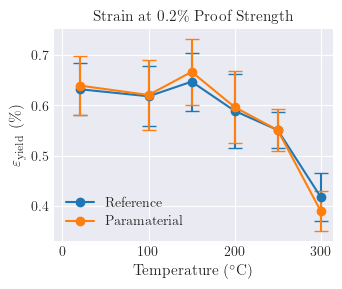

In [31]:
# convert analysis PS_0.002_0 to percent
analysis_table['PS_0.002_0'] = analysis_table['PS_0.002_0'] *100
analysis_table['std_PS_0.002_0'] = analysis_table['std_PS_0.002_0'] *100
# make a plot comparing PS_0.002_0, include error bars for std deviations
ax=reference_table.plot(x='temperature', y='PS_0.002_0', yerr='std_PS_0.002_0', label='Reference', marker='o',  capsize=5, figsize=(3.6,2.75))
analysis_table.plot(x='temperature', y='PS_0.002_0', yerr='std_PS_0.002_0', label='Paramaterial', marker='o', capsize=5, ax=ax)
ax.set(xlabel='Temperature ($^{\circ}$C)', ylabel='$\\varepsilon_{\\text{yield}}$ (\%)', title='Strain at 0.2\% Proof Strength',xlim=(-10, None));

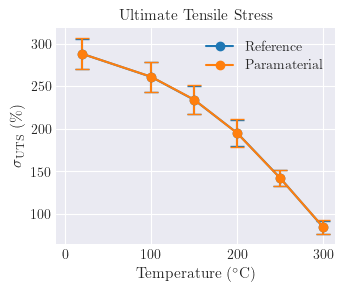

In [32]:
# plot UTS_1
ax=reference_table.plot(x='temperature', y='UTS_1', yerr='std_UTS_1', label='Reference', marker='o',  capsize=5, figsize=figsize)
analysis_table.plot(x='temperature', y='UTS_1', yerr='std_UTS_1', label='Paramaterial', marker='o', capsize=5, ax=ax)
ax.set(xlabel='Temperature ($^{\circ}$C)', ylabel='$\sigma_{\\text{UTS}}$ (\%)', title='Ultimate Tensile Stress',xlim=(-10, None));

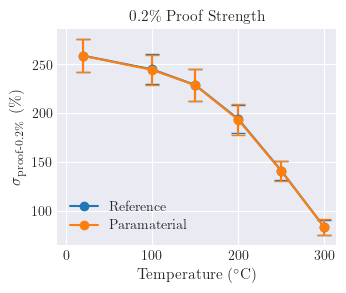

In [33]:
# plot PS_0.002_1
ax=reference_table.plot(x='temperature', y='PS_0.002_1', yerr='std_PS_0.002_1', label='Reference', marker='o',  capsize=5, figsize=figsize)
analysis_table.plot(x='temperature', y='PS_0.002_1', yerr='std_PS_0.002_1', label='Paramaterial', marker='o', capsize=5, ax=ax)
ax.set(xlabel='Temperature ($^{\circ}$C)', ylabel='$\sigma_{\\text{proof-0.2\%}}$ (\%)', title='0.2\% Proof Strength',xlim=(-10, None));